In [1]:
%pip install torch

Note: you may need to restart the kernel to use updated packages.


**Import libraries and check available devices**

In [1]:
import torch

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

**Download MNIST dataset.**

The MNIST database contains 60,000 training images and 10,000 testing images.

In [2]:
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 14995272.01it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 559797.47it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3868311.67it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9338494.49it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



**Print train_data and test_data size to check the data loaded properly**

In [4]:
print(train_data)
print(test_data)
print(train_data.data.size())

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()
torch.Size([60000, 28, 28])


**Visualization of MNIST dataset**

One training datapoint

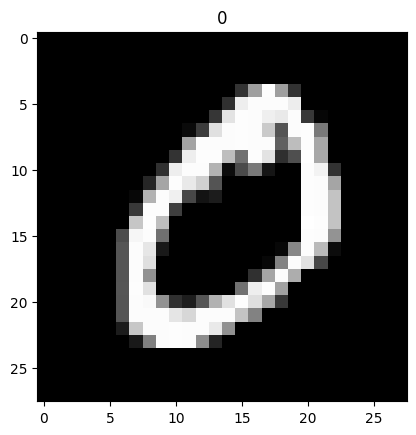

In [5]:
import matplotlib.pyplot as plt
plt.imshow(train_data.data[1], cmap='gray')
plt.title('%i' % train_data.targets[1])
plt.show()

**Multiple training datapoints**

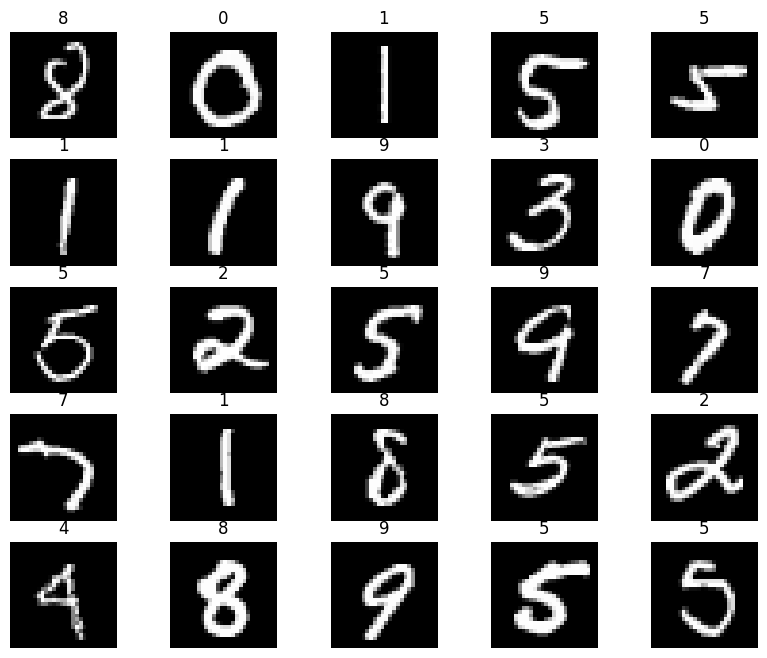

In [6]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

**Preparing data for training with DataLoaders**

In [8]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data,
                                          batch_size=128,
                                          shuffle=True,
                                          num_workers=1),

    'test'  : torch.utils.data.DataLoader(test_data,
                                          batch_size=128,
                                          shuffle=True,
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7c6dda208160>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7c6dda209720>}

**Define the Convolutional Neural Network model**

Conv2d: Applies a 2D convolution over an input signal composed of several input planes.
Parameters

in_channels (int) — Number of channels in the input image

out_channels (int) — Number of channels produced by the convolution

kernel_size (int or tuple) — Size of the convolving kernel

stride (int or tuple, optional) — Stride of the convolution. Default: 1

padding (int or tuple, optional) — Zero-padding added to both sides of the input. Default: 0

In [10]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x    # return x for visualization

In [11]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


**Define loss function**

In [12]:
loss_func = nn.CrossEntropyLoss()
loss_func

CrossEntropyLoss()

**Define a Optimization Function**

lr(Learning Rate): Rate at which our model updates the weights in the cells each time back-propagation is done.

In [13]:
from torch import optim
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

**Train the model**

Create a function called train() and pass num of epochs, model and data loaders as input parameters.

num_epochs: Number of times our model will go through the entire training dataset

In [14]:
from torch.autograd import Variable

num_epochs = 10
def train(num_epochs, cnn, loaders):

    cnn.train()

    # Train the model
    total_step = len(loaders['train'])

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):

            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]
            loss = loss_func(output, b_y)

            # clear gradients for this training step
            optimizer.zero_grad()

            # backpropagation, compute gradients
            loss.backward()
            # apply gradients
            optimizer.step()

            if (i+1) % 128 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
                pass

        pass


    pass
train(num_epochs, cnn, loaders)


Epoch [1/10], Step [128/469], Loss: 0.1051
Epoch [1/10], Step [256/469], Loss: 0.1251
Epoch [1/10], Step [384/469], Loss: 0.0499
Epoch [2/10], Step [128/469], Loss: 0.0602
Epoch [2/10], Step [256/469], Loss: 0.0286
Epoch [2/10], Step [384/469], Loss: 0.0227
Epoch [3/10], Step [128/469], Loss: 0.0464
Epoch [3/10], Step [256/469], Loss: 0.1004
Epoch [3/10], Step [384/469], Loss: 0.0096
Epoch [4/10], Step [128/469], Loss: 0.0344
Epoch [4/10], Step [256/469], Loss: 0.0319
Epoch [4/10], Step [384/469], Loss: 0.0306
Epoch [5/10], Step [128/469], Loss: 0.0272
Epoch [5/10], Step [256/469], Loss: 0.0045
Epoch [5/10], Step [384/469], Loss: 0.0267
Epoch [6/10], Step [128/469], Loss: 0.0587
Epoch [6/10], Step [256/469], Loss: 0.0072
Epoch [6/10], Step [384/469], Loss: 0.0289
Epoch [7/10], Step [128/469], Loss: 0.1197
Epoch [7/10], Step [256/469], Loss: 0.0127
Epoch [7/10], Step [384/469], Loss: 0.0108
Epoch [8/10], Step [128/469], Loss: 0.0881
Epoch [8/10], Step [256/469], Loss: 0.0353
Epoch [8/10

**Evaluate the model on test data**

In [15]:
def test():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            pass
        print('Test Accuracy of the model: %.2f' % accuracy)
        pass
test()

Test Accuracy of the model: 0.94


**Print 10 predictions from test data**

In [ ]:
sample = next(iter(loaders['test']))
imgs, lbls = sample
actual_number = lbls[:20].numpy()
actual_number

array([6, 2, 3, 5, 9, 7, 0, 6, 9, 6, 5, 2, 8, 0, 2, 9, 7, 8, 7, 1])

In [ ]:
test_output, last_layer = cnn(imgs[:20])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(f'Prediction number: {pred_y}')
print(f'Actual number: {actual_number}')

Prediction number: [6 2 3 5 9 7 0 6 9 6 5 2 8 0 2 9 7 8 7 1]
Actual number: [6 2 3 5 9 7 0 6 9 6 5 2 8 0 2 9 7 8 7 1]
